### This notebook estimates the maximum number of electrons per pixel the spaceX satellites would produce.
#### In this notebook we explore the 2D parameter space formed by angular velocity and FWHM. There are three discrete values for the satellite height: 320km, 550km, and 1150km. For simplicity, we assume a zenith angle of 40 degrees (this is a parameter at the very top of the notebook so that is can be easily changed) and the orbit of the satellite goes through zenith. The angular velocity is then a function of the height. If the size of the satellite is 3m, the FWHM of the trail will also be a function of the height.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import galsim
import matplotlib.pyplot as plt
import os
from lsst.utils import getPackageDir

In [2]:
heightsKm = [320, 550, 1150] #height in km
zenithADeg = 40 #zenith angle in deg
satSizeM = 3 #size in meter

### Determine angular velocity from height
Tony sent this plot 

![this plot](./plots/Sat-ang-vel.png)

But it won't be very easy to interpolate to 320, 550, and 1150km, as things do not appear to be linear here.
Below, we will use some high-school physics to do a rough calculation, and see how well we can match this.

In [3]:
G = 6.673e-11  #gravitational constant
Me = 5.97e24  #mass of earth in kg
Re = 6371e3  #radius of earth in m
def calcAngularV(heightKm, zenithADeg):
    '''
    inputs: 
        heightM: satellite height in kilometers
        zenithADeg: zenith angle in degree
    output:
        angular velocity as seen from earth, in deg per minute
    '''
    h=heightKm*1000 #height in meter
    za = np.radians(zenithADeg)
    omega = np.sqrt(G*Me/(Re+h)**3) #angular velocity as seen from center of earth
    orbitV = omega*(Re+h) #orbit velocity
    x = np.arcsin(Re*np.sin(za)/(Re+h)) ## angle between line of sight and (Re+h)
    tanV = orbitV*np.cos(x) #project orbitV to perpendicular to line of sight
    if np.isclose(x,0):
        d = h
    else:
        d = np.sin(za-x)*Re/np.sin(x) #distance between satellite and earth
    angularV = tanV/d  #angular velocity as seen from earth

    angularV = angularV/np.pi*180*60  #convert from radian/sec into deg/min
    return angularV

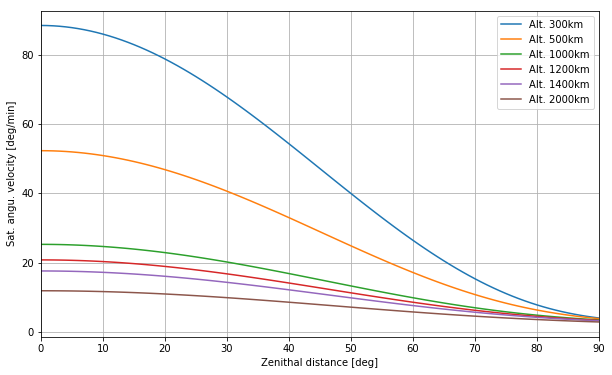

In [4]:
av = np.zeros((6,91))
zas = np.linspace(0,90,91)
hs = [300,500,1000,1200,1400,2000]
fig, ax = plt.subplots(figsize=(10,6))
for hi,h in enumerate(hs):
    for zai, za in enumerate(zas):
        av[hi, zai] = calcAngularV(h, za)
    plt.plot(zas, av[hi,:], label='Alt. %dkm'%h)
plt.legend()
plt.xlim([0, 90])
plt.xlabel('Zenithal distance [deg]')
plt.ylabel('Sat. angu. velocity [deg/min]')
plt.grid()
# This seems to match pretty well. So we will use this to calculate the angular velocity for the given heights.

In [5]:
nHeight = len(heightsKm)
angularVs = np.zeros(nHeight)
for i, heightKm in enumerate(heightsKm):
    angularVs[i] = calcAngularV(heightKm, zenithADeg) 
angularVs

array([51.04998837, 30.08345585, 14.69742917])

In [6]:
def calcFWHM(heightKm, zenithADeg, satSizeM):
    '''
    inputs: 
        heightM: satellite height in kilometers
        zenithADeg: zenith angle in degree
        satSizeM: satellite size in meter
    output:
        angular velocity as seen from earth, in deg per minute
    '''
    h=heightKm*1000 #height in meter
    za = np.radians(zenithADeg)
    x = np.arcsin(Re*np.sin(za)/(Re+h)) ## angle between line of sight and (Re+h)
    s = satSizeM*np.cos(x) #project satellite size to perpendicular to line of sight
    if np.isclose(x,0):
        d = h
    else:
        d = np.sin(za-x)*Re/np.sin(x) #distance between satellite and earth
    angularS = s/d  #angular size as seen from earth

    angularS = angularS/np.pi*180*3600  #convert from radian into arcsec
    return angularS

In [7]:
#sanity check: when size is 4m, at zenith, 550km height, we know it is 1.5 arcsec
fwhm1 = calcFWHM(550, 0, 4)
fwhm2 = 4/550e3/np.pi*180*3600
print(fwhm1, fwhm2, fwhm1-fwhm2)

1.5001076817970644 1.5001076817970644 0.0


In [8]:
fwhms = np.zeros(nHeight)
angularVs = np.zeros(nHeight)
for i, heightKm in enumerate(heightsKm):
    fwhms[i] = calcFWHM(heightKm, zenithADeg, satSizeM)
    angularVs[i] = calcAngularV(heightKm, zenithADeg) #convert from deg/min
    print('height = %dkm, FWHM = %.2f arcsec, angular velocity = %.2f deg/sec'%(heightKm, fwhms[i], angularVs[i]/60 ))

height = 320km, FWHM = 1.19 arcsec, angular velocity = 0.85 deg/sec
height = 550km, FWHM = 0.71 arcsec, angular velocity = 0.50 deg/sec
height = 1150km, FWHM = 0.36 arcsec, angular velocity = 0.24 deg/sec


### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. 

In [9]:
# full_well for a 30s visit, in e-
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.
bias_offset = 45e3
bias_offset_subtract = 0 #According to Steve R. and Aaron R., this should not be a factor

## We first determine what fraction of the flux will be in the center/brightest pixel

In [10]:
#Assume it moves along pixel grid. The time its image center moves from one pixel center to the next is dt
dts = np.zeros(nHeight)
for i, heightKm in enumerate(heightsKm):
    dts[i] = 0.2/(angularVs[i]/60*3600) # in seconds

#### Approximate it as a source which appears at one pixel center for dt, then disappears from there, and instantly appears at the next pixel center for dt. During each dt, the source deposit a flux profile that is a Gaussian with FWHM of 1.5 arcsec.
So we are just overlapping Gaussians whose centers are 0.2 arcsec apart. Considering that the FWHM is much larger than pixel size, the top of the Gaussians are pretty flat. So this should be a pretty good approximation.
This slightly overestimates the flux, because having the Gaussian moving across the pixel in dt would yield a smaller flux for the pixel, compared to when the center of the Gaussian is overlapped with the pixel center during dt.

[0.15675568 0.25854633 0.48288462]


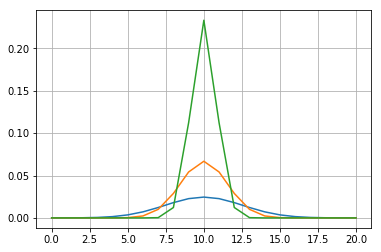

In [11]:
ratio = np.zeros(3)
stamp_size = 21
pixel_scale = 0.2
for i, fwhm in enumerate(fwhms):
    psf = galsim.Gaussian(fwhm=fwhm)
    img = galsim.ImageD(stamp_size, stamp_size, scale=pixel_scale)
    psf = psf.withFlux(1) #unit flux
    psf.drawImage(image=img)
    ratio[i] = sum(img.array[10,:])/np.sum(img.array)
    plt.plot(img.array[10,:])
print(ratio)
plt.grid()

### Baseline LSST system, as defined in syseng_throughput

In [12]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations

In [13]:
exptime=15 
nexp=2
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
effarea=np.pi*(6.423/2*100)**2
X=1.0

# PhotometricParameters object for standard m5 calculations.
photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

### Let's make sure we can reproduce standard m5 results

In [14]:
m5 = st.makeM5(hardware, system, darksky=None, 
                      exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                      effarea=effarea, X=1.0)

In [15]:
m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


### Set up the dataframe

In [16]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y','AngularV','FWHM')
properties = []
for heightKm in heightsKm:
    properties.append('%dkm'%heightKm)
d = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for i, heightKm in enumerate(heightsKm):
    key = '%dkm'%heightKm
    d[key].loc['AngularV'] = angularVs[i]
    d[key].loc['FWHM'] = fwhms[i]

### Calculate the saturation limits under darksky: the source should have solar SED

In [17]:
# change exposure to dt

for f in system:
    satellite = Sed()
    satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
    fNorm = satellite.calcFluxNorm(0, system[f])
    # print('fNorm = %.2e'%fNorm)
    satellite.multiplyFluxNorm(fNorm)

    for i, heightKm in enumerate(heightsKm):
        dt = dts[i]
        photParams_dt = PhotometricParameters(exptime=dt, nexp=1,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)
        adu = satellite.calcADU(system[f], photParams=photParams_dt)
    
        key = '%dkm'%heightKm
        adu0 = adu*ratio[i]
        #because we assumed a m=0 star
        # we use gain=1.0, so adu = number of e-
        # we also get rid of skycounts from each pixel. This has miminal effect on results
        d[key].loc[f] = np.log10(adu0/(full_well-m5.skyCounts.loc[f]-bias_offset_subtract))/2*5

In [18]:
d

,320km,550km,1150km
u,1.594804,2.712262,4.168240
g,2.987306,4.104763,5.560742
r,2.768388,3.885846,5.341824
i,2.473121,3.590578,5.046557
z,2.079826,3.197283,4.653262
y,1.289837,2.407295,3.863273
AngularV,51.049988,30.083456,14.697429
FWHM,1.190874,0.713735,0.363500


#### Double-check: do the same calculation using zero points

In [19]:
d_zp = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
key = 'SatLim'
for f in system:
    for i, heightKm in enumerate(heightsKm):
        key = '%dkm'%heightKm
        #number of electrons we can accomodate for the source in dt sec
        ne = (full_well-m5.skyCounts[f]-bias_offset_subtract)/ratio[i]
        #number of electrons we can accomodate for this source in 1 sec
        ne = ne/dts[i]
        d_zp[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [20]:
d_zp

,320km,550km,1150km
u,1.594804,2.712262,4.168240
g,2.987306,4.104763,5.560742
r,2.768388,3.885846,5.341824
i,2.473121,3.590578,5.046557
z,2.079826,3.197283,4.653262
y,1.289837,2.407295,3.863273
AngularV,NaN,NaN,NaN
FWHM,NaN,NaN,NaN


In [21]:
round(d_zp - d)  #should be idential to above calculations

,320km,550km,1150km
u,0.0,0.0,0.0
g,-0.0,-0.0,-0.0
r,0.0,0.0,0.0
i,-0.0,-0.0,-0.0
z,0.0,0.0,-0.0
y,0.0,0.0,0.0
AngularV,NaN,NaN,NaN
FWHM,NaN,NaN,NaN


### Make peak electron counts vs. mag plot (We use 550km orbit height as the example)

In [22]:
idx = properties.index('550km')
heightKm = heightsKm[idx]
angularV = angularVs[idx]
fwhm = fwhms[idx]
dt = dts[idx]
pRatio = ratio[idx]

photParams_dt = PhotometricParameters(exptime=dt, nexp=1,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')

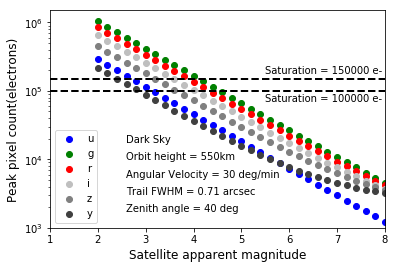

In [23]:
magLow = 2
magHigh = 8
magStep = 0.2
nMag = int((magHigh-magLow)/magStep)

fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    if len(f)>1:
        continue
    mags = []
    npeaks = []
    flatsource = Sed()
    flatsource.setFlatSED()
    
    adu = flatsource.calcADU(system[f], photParams=photParams_dt)
    adu0 = adu*pRatio #a m=0 start produces this adu0 in the center pixel
    for m in range(nMag+1):
        mag = magLow + magStep * m
        mags.append(mag)
        npeak = adu0*10**(-mag/2.5)+m5.skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
    d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.plot([magLow-1,magHigh],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(magHigh-2.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([magLow-1,magHigh],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(magHigh-2.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.18, "Zenith angle = %.0f deg"%zenithADeg, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.24, "Trail FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.30, "Angular Velocity = %.0f deg/min"%angularV, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.36, "Orbit height = %dkm"%heightKm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.42, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(magLow-1,magHigh)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);

In [24]:
d_plot.SatLimFromPlot.loc['AngularV'] = angularV
d_plot.SatLimFromPlot.loc['FWHM'] = fwhm
#check consistency with above calculations.
d_plot.join(d)

,SatLimFromPlot,320km,550km,1150km
u,2.800000,1.594804,2.712262,4.168240
g,4.200000,2.987306,4.104763,5.560742
r,4.000000,2.768388,3.885846,5.341824
i,3.600000,2.473121,3.590578,5.046557
z,3.200000,2.079826,3.197283,4.653262
y,2.600000,1.289837,2.407295,3.863273
AngularV,30.083456,51.049988,30.083456,14.697429
FWHM,0.713735,1.190874,0.713735,0.363500


### We can use the zeropoints to do the same calculations and make the same plot

for 5th mag, under dark sky, band u, peak e per pixel = 18310
for 5th mag, under dark sky, band g, peak e per pixel = 65996
for 5th mag, under dark sky, band r, peak e per pixel = 54282
for 5th mag, under dark sky, band i, peak e per pixel = 41810
for 5th mag, under dark sky, band z, peak e per pixel = 29955
for 5th mag, under dark sky, band y, peak e per pixel = 15926


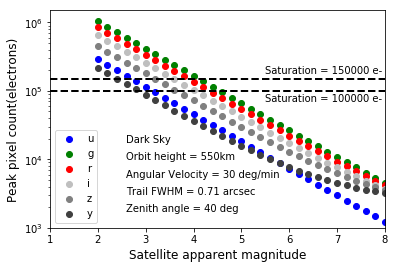

In [25]:
d_plot_zp = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')
fig, ax = plt.subplots()
peak_e_mag_5 = []
for i,f in enumerate(filterlist):
    if len(f)>1:
        continue
    mags = []
    npeaks = []
    for m in range(nMag+1):
        mag = magLow + magStep * m
        mags.append(mag)
        #for a source of mag, how many electrons is produced on detector in a second?
        ne = 10**((m5.Zp_t[f] - mag)/2.5)
        # what about dt seconds
        ne *= dt
        # how many fall into the center pixel? on top of the background and others
        npeak = ne*pRatio+ m5.skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
        d_plot_zp.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
        if mag==5.0:
            peak_e_mag_5.append(npeak)
            print('for 5th mag, under dark sky, band %s, peak e per pixel = %.0f'%(f,npeak))
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
plt.plot([magLow-1,magHigh],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(magHigh-2.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([magLow-1,magHigh],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(magHigh-2.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.18, "Zenith angle = %.0f deg"%zenithADeg, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.24, "Trail FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.30, "Angular Velocity = %.0f deg/min"%angularV, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.36, "Orbit height = %dkm"%heightKm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.42, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(magLow-1,magHigh)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12)
plt.savefig('Peak_count_by_band_%dkm_darkSky.pdf'%heightKm)

In [26]:
round(d_plot - d_plot_zp) #should be identical to calculations using zero points

,SatLimFromPlot
u,0.0
g,0.0
r,0.0
i,0.0
z,0.0
y,0.0
AngularV,NaN
FWHM,NaN


#### Now do the same thing for bright sky. We will only do the calculations using zero points below.

### First, what magnitudes do we use for bright sky?

In [27]:
#Tony sent these values from DECam. These are ~50 deg from full moon
skyBrightMag = {'u': 17.7, 'g':19.4, 'r':19.7, 'i':19.4, 'z':18.2, 'y':17.7}

In [28]:
#From Peter's sky brightness model
# https://github.com/lsst/sims_skybrightness/blob/master/examples/mag_range.ipynb
# These are brightest mags under condition: (sun altitude < -12)
skyBrightMag1 = {'u': 18.5, 'g':18.0, 'r':18.1, 'i':18.3, 'z':17.9, 'y':16.9}

#Peter also provided the min and max values from cadence simulations
# https://github.com/lsst-sims/sims_featureScheduler_runs1.4/blob/master/baseline/Skybrightnesses.ipynb
# These are brightest mags under condition: (sun altitude < -18 deg and Moon altitude > 0 )
skyBrightMag2 = {'u': 22.4, 'g':17.0, 'r':16.9, 'i':17.1, 'z':17.1, 'y':17.0}

#### Before we understand the difference above better, we will just use Tony's values

#### We will add additional 0.4 mag to the sky background, due to solar cycle

Tony wrote : Even the 
11 yr solar cycle gives 0.5 mag change in v band.  For our immediate 
SpaceX purpose it would be appropriate to generate only two plots, one 
for bright time and one for dark time.  In the mid 2020s we enter solar 
max, so add 0.4 mag in v band to sky.

In [29]:
skyCounts = {}
for f in system:
    skyCount = 10**((0.4+m5.skyMag[f]-skyBrightMag[f])/2.5)*m5.skyCounts[f] # we can actually simply calculate sky count this way.
    skyCounts[f]=skyCount
    print('%.2f'%(skyCount)) # this is just to double check

14856.67
7926.80
8261.24
4696.91
9353.64
4575.58


In [30]:
#use zero points to calculate saturation magnitudes under bright sky
d_zp_bright = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for f in system:
    for i, heightKm in enumerate(heightsKm):
        key = '%dkm'%heightKm
        #number of electrons we can accomodate for the source in dt sec
        ne = (full_well-skyCounts[f]-bias_offset_subtract)/ratio[i]
        #number of electrons we can accomodate for this source in 1 sec
        ne = ne/(dts[i])
        d_zp_bright[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [31]:
d_zp_bright - d_zp

,320km,550km,1150km
u,0.112656,0.112656,0.112656
g,0.058527,0.058527,0.058527
r,0.028598,0.028598,0.028598
i,0.025107,0.025107,0.025107
z,0.056924,0.056924,0.056924
y,0.041649,0.041649,0.041649
AngularV,NaN,NaN,NaN
FWHM,NaN,NaN,NaN


### Make peak electron counts vs. mag plot under bright sky (We use 550km orbit height as the example)

In [32]:
idx = properties.index('550km')
heightKm = heightsKm[idx]
angularV = angularVs[idx]
fwhm = fwhms[idx]
dt = dts[idx]
pRatio = ratio[idx]

photParams_dt = PhotometricParameters(exptime=dt, nexp=1,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

for 5th mag, under bright sky, band u, peak e per pixel = 33086
for 5th mag, under bright sky, band g, peak e per pixel = 73846
for 5th mag, under bright sky, band r, peak e per pixel = 58160
for 5th mag, under bright sky, band i, peak e per pixel = 45212
for 5th mag, under bright sky, band z, peak e per pixel = 37525
for 5th mag, under bright sky, band y, peak e per pixel = 21481


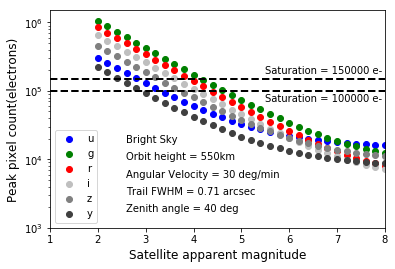

In [33]:
d_plot_zp_bright = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float') # b for bright sky
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    if len(f)>1:
        continue
    mags = []
    npeaks = []
    for m in range(nMag+1):
        mag = magLow + magStep * m
        mags.append(mag)
        #for a source of mag, how many electrons is produced on detector in a second?
        ne = 10**((m5.Zp_t[f] - mag)/2.5)
        # what about dt seconds
        ne *= dt
        # how many fall into the center pixel? on top of the background and others
        npeak = ne*pRatio+ skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
        d_plot_zp_bright.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
        if mag==5.0:
            peak_e_mag_5.append(npeak)
            print('for 5th mag, under bright sky, band %s, peak e per pixel = %.0f'%(f,npeak))
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
plt.plot([magLow-1,magHigh],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(magHigh-2.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([magLow-1,magHigh],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(magHigh-2.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.18, "Zenith angle = %.0f deg"%zenithADeg, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.24, "Trail FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.30, "Angular Velocity = %.0f deg/min"%angularV, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.36, "Orbit height = %dkm"%heightKm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.42, "Bright Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(magLow-1,magHigh)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12)
plt.savefig('Peak_count_by_band_%dkm_brightSky.pdf'%heightKm)

In [34]:
d_plot_zp_bright - d_plot_zp

,SatLimFromPlot
u,0.2
g,0.0
r,0.0
i,0.2
z,0.2
y,0.0
AngularV,NaN
FWHM,NaN
